## EDA (Exploratory Data Analysis)

There are three main data files:
 - gender_submission.csv (Results to be evaluated)
 - test.csv
 - dataset.csv

The output of this is saved in `../data/eda_step1.csv`
### Imputation

__Missing data:__ This needs imputation. We shall talk about strategies for these differently.

 | Feature | Training missing | Test missing |
 | -- | -- | --|
 | Age | 177 or 20% | 86 or 20.5% | 
 | Cabin | 687 or 77% | 327 or 78% |
 | Fare | 15 or 1.6% | 2 or 0.47 % |
 | Embarked | 2 or 0.2% | 0 |


#### Fare
It has only 15 places where the value is 0.0. Initial plan is to replace it by median of the `Pclass`. It is reasonable.


#### Age
The age is missing in 177 or (20% of samples). Initial plan is to impute it by median of `Pclass`, `Sex`.

| Pclass | Male (median-age) | Female (Median-age) |
|--|--|--|
| 1 | 40.0 | 35.0 |
| 2 | 30.0 | 28.0 |
| 3 | 25.0 | 21.5 |


#### Cabin
It has most amount of missing data. 687 out of 891 (77%) training samples. It is used to extract the `Deck` information from it. It is dropped after that.

For the missing data the `Deck` is imputed by a class `DecisionTreeClassifier`. We should be able to infer this from `Pclass` and `Fare` column. 

#### Embarked
 
### Feature Engineering:

We have these features:
1. Categorical:
    - 'Pclass': Passenger class 1 2 or 3
    - 'Sex': male or female
    - 'Embarked': Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton
    - Added: Reasoning below.
       - 'TicketPrefix': Extracted from 'Ticket'
       - 'Deck': Extracted from 'Ticket'
       - 'FamilySizeCategory': Extracted from 'Name' => Lastname
       - 'Title': Extracted from 'Name'
    - Removed: 
       - 'Name': Surname, Title Firstname (Braund, Mr. Owen Harris or Masselmani, Mrs. Fatima)
       - 'Ticket': Ticket Number in format category-number. Groups may have same ticket number
       - 'Cabin': The lodging room number. In format deck-number
       - 'PassengerId': to be removed
2. Numberic:
    - 'Age': Numeric
    - 'Fare': Ticket price
    - Added: Reasoning below.
       - 'FamilySize' = SibSp + Parch
       - 'TicketGroupSize'
       - 'SurnameGroupSize'
    - Removed:
       - 'SibSp': Siblings or spoucses onboard 
       - 'Parch': parents or children aboard

Looked at the features like `Cabin, Name, Ticket` to extract meaningful features. In future we can also look at converting `Fare` to a class like `Low, Medium or High` to avoid some outliers. 

#### `Cabin` feature
The cabin feature is interesting. It features the cabin number in for $D{n}$ where n is a number and $D$ is the deck. Once imputed we can extract a feature called `Deck` from it and remove this column from training set. The `Deck` can then be OHE (One Hot Encoded)

### `Name` feature
The `Name` encodes the information in a interesting way. Its contains:
 - Title: as one of `"Mrs|Mr|Miss|Master|Don|Rev|Dr|Mme|Ms|Major|Capt|Col|Countess"`. We add `other` in two cases where it is not available. Mind the order of `Mrs|Mr` left to right.
 - Surname: extract sirname as first word in name. Can provide insight into families togetehr.
 - SurnameGroupSize: We can then create a column with group size by last name. For example how many 'Smiths' or 'Johns' travelling together.


| Title | Count |
|--|--|
| Mr | 511 |
| Miss | 180 |
| Mrs | 125 |
|  Master | 40 |
|  Dr, Col | 10 |
|  Rev | 6 |
| Major, Other | 2 |
|  Don, Mme, Ms, Capt, Countess | 1 |


The surname histogram. Means that 534 are single sir-name, 83 groups of 2 share sirname, 28 groups of 3 share sirname.


 | Sirname Group Size |	Count |
 |--| --|
 | 1	| 534 |
 | 2	| 166 |
 | 3	| 84 |
 | 4	| 56 |
 | 5	| 30 |
 | 6	| 9 |
 | 7	| 7 |
 | 9    | 5 |


### `Ticket` feature
The `Ticket` feature has interesting data. It's format is `prefix+number`. The model can learn from prefix.
 - TicketPrefix: Extract this feature
 - TicketGroupSize: Same ticket is used by a group. 

 | TicketGroupSize | Count | 
 |--|--|
 | 1 | 	547 |
 | 2 | 	94 |
 | 3 | 	21 |
 | 4 | 	11 |
 | 5 | 	2 |
 | 6 | 	3 |
 | 7 | 	3 |


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset = pd.read_csv('../data/train.csv')
submit = pd.read_csv('../data/test.csv')
len(dataset), len(submit)

(891, 418)

In [3]:
# Print the columns
# SibSp: of siblings / spouses aboard the Titanic
# Parch: of parents / children aboard the Titanic
print(dataset.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [4]:
dataset.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Missing Data

Let us look at the count of missing data in each column for both testing and training set.

In [5]:
def print_missing_data(data):
    null_counts = data.isnull().sum()
    # Print the missing data count and percentage
    null_counts = data.isnull().sum()
    # Set 'Fare' to count of zeros
    null_counts['Fare'] = data[data['Fare'] == 0].shape[0]
    null_counts_percentage = null_counts / len(data) * 100
    # Print the missing data count and percentage
    # Combine the counts and percentages into a single DataFrame
    missing_data = pd.DataFrame({
        'count': null_counts,
        'percentage': null_counts_percentage
    })

    # Print the combined DataFrame, ignore the count of zeros
    print(missing_data[missing_data['count'] != 0])

In [6]:
print_missing_data(dataset)

          count  percentage
Age         177   19.865320
Fare         15    1.683502
Cabin       687   77.104377
Embarked      2    0.224467


In [7]:
print_missing_data(submit)

       count  percentage
Age       86   20.574163
Fare       2    0.478469
Cabin    327   78.229665


## Missing Data: Age

Look at the missing age data by Sex and class.

In [8]:
def print_missing_age(data):
    # Missing "Age" by "Sex", "Pclass", "Embarked" counts
    age_missing = []
    male_missing_age = data[data['Sex'] == 'male']['Age'].isnull().sum()
    female_missing_age = data[data['Sex'] == 'female']['Age'].isnull().sum()

    for pclass in [1, 2, 3]:
        class_count = data[data['Pclass'] == pclass]['Age'].isnull().sum()
        male_count = data[(data['Pclass'] == pclass) & (
            data['Sex'] == 'male')]['Age'].isnull().sum()
        female_count = data[(data['Pclass'] == pclass) & (
            data['Sex'] == 'female')]['Age'].isnull().sum()
        male_median = data[(data['Pclass'] == pclass) & (
            data['Sex'] == 'male')]['Age'].median()
        female_median = data[(data['Pclass'] == pclass) & (
            data['Sex'] == 'female')]['Age'].median()
        age_missing.append((pclass, class_count, male_count, female_count, male_median, female_median))


    # median and mean of Age by Sex, Pclass, Embarked
    male_median_age = data[data['Sex'] == 'male']['Age'].median()
    female_median_age = data[data['Sex'] == 'female']['Age'].median()

    missing_age_embarked = []
    for embarked in ['S', 'C', 'Q']:
        missing_age_embarked.append(
            data[data['Embarked'] == embarked]['Age'].isnull().sum())


    print("Missing age counts:")
    print(
        f"         male {male_missing_age} ({male_median_age}), female {female_missing_age} ({female_median_age})")
    print(
        f"class 1: male {age_missing[0][2]} ({age_missing[0][4]}), female {age_missing[0][3]} ({age_missing[0][5]})")
    print(
        f"class 2: male {age_missing[1][2]} ({age_missing[1][4]}), female {age_missing[1][3]} ({age_missing[1][5]})")
    print(
        f"class 3: male {age_missing[2][2]} ({age_missing[2][4]}), female {age_missing[2][2]} ({age_missing[2][5]})")
    print(
        f"embarked at S: {missing_age_embarked[0]}, C: {missing_age_embarked[1]}, Q: {missing_age_embarked[2]}")

In [9]:
print_missing_age(dataset)

Missing age counts:
         male 124 (29.0), female 53 (27.0)
class 1: male 21 (40.0), female 9 (35.0)
class 2: male 9 (30.0), female 2 (28.0)
class 3: male 94 (25.0), female 94 (21.5)
embarked at S: 90, C: 38, Q: 49


In [10]:
print_missing_age(submit)

Missing age counts:
         male 61 (27.0), female 25 (27.0)
class 1: male 7 (42.0), female 2 (41.0)
class 2: male 4 (28.0), female 1 (24.0)
class 3: male 50 (24.0), female 50 (22.0)
embarked at S: 42, C: 20, Q: 24


## Missing Data: Cabin


In [11]:
def print_missing_cabin(data):
    cabin_missing_data = data['Cabin'].isnull().sum()
    cabin_missing_data_percentage = (
        cabin_missing_data / len(data['Cabin'])) * 100
    print(
        f"Cabin missing: {cabin_missing_data} = {cabin_missing_data_percentage:.2f}%")
    # Missing by class
    cabin_missing_class_1 = data[data['Pclass']
                                    == 1]['Cabin'].isnull().sum()
    class1_cabins = data[data['Pclass'] == 1]['Pclass'].count()
    cabin_missing_class_1_percentage = (
        cabin_missing_class_1 / class1_cabins) * 100
    cabin_missing_class_2 = data[data['Pclass']
                                 == 2]['Cabin'].isnull().sum()
    class2_cabins = data[data['Pclass'] == 2]['Pclass'].count()
    cabin_missing_class_2_percentage = (
        cabin_missing_class_2 / class2_cabins) * 100
    cabin_missing_class_3 = data[data['Pclass']
                                 == 3]['Cabin'].isnull().sum()
    class3_cabins = data[data['Pclass'] == 3]['Pclass'].count()
    cabin_missing_class_3_percentage = (
        cabin_missing_class_3 / class3_cabins) * 100
    print(
        f"class 1 missing:  {cabin_missing_class_1} / {class1_cabins} = {cabin_missing_class_1_percentage:.2f}%")
    print(
        f"class 2 missing: {cabin_missing_class_2} / {class2_cabins} = {cabin_missing_class_2_percentage:.2f}%")
    print(
        f"class 3 missing: {cabin_missing_class_3} / {class3_cabins} = {cabin_missing_class_3_percentage:.2f}%")

In [12]:
print("Training dataset missing cabins:")
print_missing_cabin(dataset)

Training dataset missing cabins:
Cabin missing: 687 = 77.10%
class 1 missing:  40 / 216 = 18.52%
class 2 missing: 168 / 184 = 91.30%
class 3 missing: 479 / 491 = 97.56%


In [13]:
print("Submit dataset missing cabins:")
print_missing_cabin(submit)

Submit dataset missing cabins:
Cabin missing: 327 = 78.23%
class 1 missing:  27 / 107 = 25.23%
class 2 missing: 86 / 93 = 92.47%
class 3 missing: 214 / 218 = 98.17%


In [14]:
def print_missing_deck(data):
    print("Missing Deck counts: ", end="")
    for deck, count in data["Deck"].value_counts().items():
        # Print deck name and count
        print(f"{deck}: {count}, ", end="")

In [15]:
# Add Deck column
dataset["Deck"] = dataset["Cabin"].str[:1]

In [16]:
print_missing_deck(dataset)

Missing Deck counts: C: 59, B: 47, D: 33, E: 32, A: 15, F: 13, G: 4, T: 1, 

In [17]:
submit["Deck"] = submit["Cabin"].str[:1]
print_missing_deck(submit)

Missing Deck counts: C: 35, B: 18, D: 13, E: 9, F: 8, A: 7, G: 1, 

In [18]:
# MIssing number of decks by Pclass
deck_by_pclass = dataset.groupby(['Pclass', 'Deck'])['Deck'].count().unstack()
print(deck_by_pclass)

Deck       A     B     C     D     E    F    G    T
Pclass                                             
1       15.0  47.0  59.0  29.0  25.0  NaN  NaN  1.0
2        NaN   NaN   NaN   4.0   4.0  8.0  NaN  NaN
3        NaN   NaN   NaN   NaN   3.0  5.0  4.0  NaN


## Missing Data: Fare

Look at the fare distribution by class. We can also infer that:

- Class 1 cabins: A, B, C and D
- Class 2 cabins: D, E and F
- Class 3 cabins: E, F and G

So it is resonable to fill missing fare by class median

In [25]:
def print_fare_stats(data):
    # Print max, mean, median, std of Fare by Deck and Pclass
    answer = data.groupby(['Deck', 'Pclass'])['Fare'].describe().unstack()
    # Print count, min, max, mean, median, std of Fare from answer
    for index, row in answer.iterrows():
        class1_count = row['count'].iloc[0]
        class1_min = row['min'].iloc[0]
        class1_max = row['max'].iloc[0]
        class1_mean = row['mean'].iloc[0]
        class1_median = row['50%'].iloc[0]
        class1_std = row['std'].iloc[0]
        print(f"Class 1: {index} ({class1_count:2.0f}:{class1_min:7.2f} to {class1_max:6.2f}), ({class1_mean:.2f}, {class1_median:.2f}, {class1_std:.2f})")
        class2_count = row['count'].iloc[1]
        class2_min = row['min'].iloc[1]
        class2_max = row['max'].iloc[1]
        class2_mean = row['mean'].iloc[1]
        class2_median = row['50%'].iloc[1]
        class2_std = row['std'].iloc[1]
        print(f"Class 2: {index} ({class2_count:2.0f}:{class2_min:7.2f} to {class2_max:6.2f}), ({class2_mean:.2f}, {class2_median:.2f}, {class2_std:.2f})")
        class3_count = row['count'].iloc[2]
        class3_min = row['min'].iloc[2]
        class3_max = row['max'].iloc[2]
        class3_mean = row['mean'].iloc[2]
        class3_median = row['50%'].iloc[2]
        class3_std = row['std'].iloc[2]
        print(f"Class 3: {index} ({class3_count:2.0f}:{class3_min:7.2f} to {class3_max:6.2f}), ({class3_mean:.2f}, {class3_median:.2f}, {class3_std:.2f})")

In [27]:
print_fare_stats(dataset)

Class 1: A (15:   0.00 to  81.86), (39.62, 35.50, 17.98)
Class 2: A (nan:    nan to    nan), (nan, nan, nan)
Class 3: A (nan:    nan to    nan), (nan, nan, nan)
Class 1: B (47:   0.00 to 512.33), (113.51, 80.00, 109.30)
Class 2: B (nan:    nan to    nan), (nan, nan, nan)
Class 3: B (nan:    nan to    nan), (nan, nan, nan)
Class 1: C (59:  26.55 to 263.00), (100.15, 83.47, 70.23)
Class 2: C (nan:    nan to    nan), (nan, nan, nan)
Class 3: C (nan:    nan to    nan), (nan, nan, nan)
Class 1: D (29:  25.93 to 113.28), (63.32, 75.25, 26.17)
Class 2: D ( 4:  12.88 to  13.79), (13.17, 13.00, 0.42)
Class 3: D (nan:    nan to    nan), (nan, nan, nan)
Class 1: E (25:  25.59 to 134.50), (55.74, 55.00, 30.39)
Class 2: E ( 4:  10.50 to  13.00), (11.59, 11.43, 1.28)
Class 3: E ( 3:   8.05 to  12.47), (11.00, 12.47, 2.55)
Class 1: F (nan:    nan to    nan), (nan, nan, nan)
Class 2: F ( 8:  10.50 to  39.00), (23.75, 26.00, 11.63)
Class 3: F ( 5:   7.65 to  22.36), (10.61, 7.65, 6.57)
Class 1: G (nan:

In [28]:
print_fare_stats(submit)

Class 1: A ( 7:  27.72 to  81.86), (44.72, 30.50, 25.40)
Class 2: A (nan:    nan to    nan), (nan, nan, nan)
Class 3: A (nan:    nan to    nan), (nan, nan, nan)
Class 1: B (18:   0.00 to 512.33), (145.56, 87.88, 130.18)
Class 2: B (nan:    nan to    nan), (nan, nan, nan)
Class 3: B (nan:    nan to    nan), (nan, nan, nan)
Class 1: C (35:  25.70 to 263.00), (121.03, 90.00, 76.46)
Class 2: C (nan:    nan to    nan), (nan, nan, nan)
Class 3: C (nan:    nan to    nan), (nan, nan, nan)
Class 1: D (11:  26.55 to  76.29), (47.31, 51.86, 19.11)
Class 2: D ( 2:  13.86 to  15.05), (14.45, 14.45, 0.84)
Class 3: D (nan:    nan to    nan), (nan, nan, nan)
Class 1: E ( 9:  26.00 to 134.50), (84.92, 83.16, 40.89)
Class 2: E (nan:    nan to    nan), (nan, nan, nan)
Class 3: E (nan:    nan to    nan), (nan, nan, nan)
Class 1: F (nan:    nan to    nan), (nan, nan, nan)
Class 2: F ( 5:  10.50 to  39.00), (22.90, 13.00, 14.73)
Class 3: F ( 3:   7.23 to   7.65), (7.37, 7.23, 0.24)
Class 1: G (nan:    nan t

# Understanding Features Classes

Look into Names. Extract the `Title` and `Sirname`

In [20]:
title_pattern = r"(Mrs|Mr|Miss|Master|Don|Rev|Dr|Mme|Ms|Major|Capt|Col|Countess)"
# Extract title from name
dataset["Title"] = dataset["Name"].str.extract(title_pattern).fillna("Other")
submit["Title"] = submit["Name"].str.extract(title_pattern).fillna("Other")

def print_title_counts(data):
    for title, count in data["Title"].value_counts().items():
        print(f"{title}: {count}, ", end="")
    print()
print_title_counts(dataset)
print_title_counts(submit)


Mr: 511, Miss: 180, Mrs: 125, Master: 40, Dr: 10, Col: 10, Rev: 6, Major: 2, Other: 2, Don: 1, Mme: 1, Ms: 1, Capt: 1, Countess: 1, 
Mr: 237, Miss: 77, Mrs: 72, Master: 20, Col: 4, Dr: 4, Don: 2, Rev: 2, 


In [21]:
# Surname
dataset["Surname"] = dataset["Name"].apply(lambda x: x.split(",")[0])
# Show how many people does a person share a surname with.
surname_counts = dataset["Surname"].value_counts()
dataset['SurnameGroupSize'] = dataset['Surname'].map(surname_counts).fillna(1)

In [22]:
def plot_histogram(data, bins=10):
    counts, bins, _ = plt.hist(data, bins=bins)
    for i in range(len(counts)):
        plt.text(bins[i] + (bins[i+1] - bins[i]) / 2, counts[i], int(counts[i]), ha='center', va='bottom')
    plt.grid(True)
    plt.show()

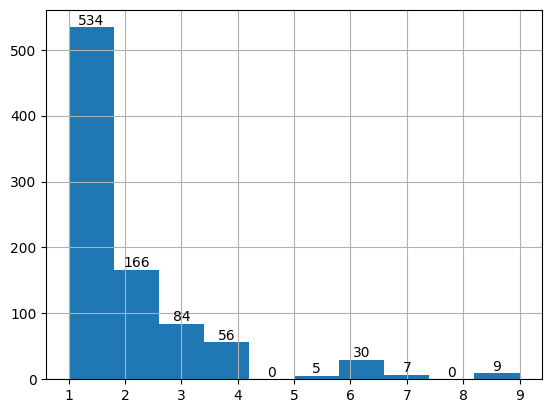

In [23]:
plot_histogram(dataset['SurnameGroupSize'], bins=10)

In [24]:
dataset.to_csv('../data/eda_step1.csv', index=False)